<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/SNS/DaCiberSalut/DaCiberSalut(histology_img_test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision timm numpy pillow gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [5]:
# Importamos librerías
import os
import zipfile
import gdown
from glob import glob
from shutil import copy2, move
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Descargar y descomprimir ZIP
url = "https://drive.google.com/uc?id=1nbw70uaIUFJgmvYwa1F5vZsJooxvHpzx"
zip_file = "verificador_histologia.zip"
extract_path = "/content/verificador_histologia"

gdown.download(url, zip_file, quiet=False)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 📁 Crear estructura de carpetas
base_dir = "/content/histology_filter_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")
classes = ["histology", "other"]

for split in [train_dir, val_dir, test_dir]:
    for c in classes:
        os.makedirs(os.path.join(split, c), exist_ok=True)


Downloading...
From (original): https://drive.google.com/uc?id=1nbw70uaIUFJgmvYwa1F5vZsJooxvHpzx
From (redirected): https://drive.google.com/uc?id=1nbw70uaIUFJgmvYwa1F5vZsJooxvHpzx&confirm=t&uuid=52f66fda-3232-4872-86a6-07d22e77c9d7
To: /content/verificador_histologia.zip
100%|██████████| 74.9M/74.9M [00:00<00:00, 205MB/s]


In [7]:
# Recolectar imágenes y repartir
all_histology = glob(os.path.join(extract_path, "histology", "*"))
all_other = glob(os.path.join(extract_path, "other", "*"))

def split_and_copy(img_list, label):
    random.shuffle(img_list)
    n = len(img_list)
    train_split = int(n * 0.7)
    val_split = int(n * 0.85)

    for i, img_path in enumerate(img_list):
        if i < train_split:
            dest = os.path.join(train_dir, label)
        elif i < val_split:
            dest = os.path.join(val_dir, label)
        else:
            dest = os.path.join(test_dir, label)
        copy2(img_path, dest)

split_and_copy(all_histology, "histology")
split_and_copy(all_other, "other")

In [8]:
# Transformaciones
IMG_SIZE = 768
BATCH_SIZE = 8
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets y loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Modelo - ResNet18
model = timm.create_model("resnet18", pretrained=True)
num_features = model.get_classifier().in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [14]:
# Entrenamiento
best_val_acc = 0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "histology_filter_model.pth")
        print("✔️ Filtro guardado con mejor validación")


Epoch 1/10, Loss: 0.3877, Val Accuracy: 1.0000
✔️ Filtro guardado con mejor validación
Epoch 2/10, Loss: 0.1062, Val Accuracy: 1.0000
Epoch 3/10, Loss: 0.0801, Val Accuracy: 1.0000
Epoch 4/10, Loss: 0.0475, Val Accuracy: 1.0000
Epoch 5/10, Loss: 0.0295, Val Accuracy: 1.0000
Epoch 6/10, Loss: 0.0221, Val Accuracy: 1.0000
Epoch 7/10, Loss: 0.0206, Val Accuracy: 1.0000
Epoch 8/10, Loss: 0.0272, Val Accuracy: 1.0000
Epoch 9/10, Loss: 0.0107, Val Accuracy: 1.0000
Epoch 10/10, Loss: 0.0475, Val Accuracy: 1.0000


Test Accuracy (verificador): 1.0000


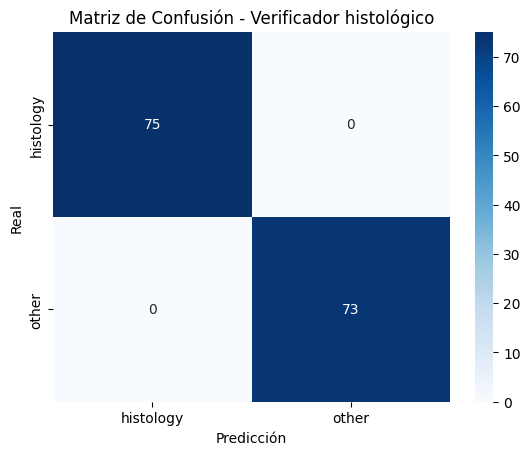

In [18]:
# Evaluación en Test
model.load_state_dict(torch.load("histology_filter_model.pth", map_location=DEVICE))
model.eval()
correct = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = correct / len(test_dataset)
print(f"Test Accuracy (verificador): {acc:.4f}")

# Matriz de Confusión
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Verificador histológico")
plt.show()